In [1]:
import numpy as np
from matplotlib import pyplot as plt

import examples
from acsbm import estimation, generation, models, utils

# Simpson's Paradox

Suppose we have a network of 1,000 nodes. Corresponding to each node $i$ are two binary variables, $W_i$ and $Z_i$. Marginally, $W_i$ and $Z_i$ are each distributed uniformly over $\{0, 1\}$, i.e., about half of nodes have $W_i = 0$ and half have $W_i = 1$---and the same for $Z_i$.

But suppose that $W$ and $Z$ are correlated. In particular, suppose that $W_i = Z_i$ with probability 0.8. The two-way table for the distribution of $(W_i, Z_i)$ then looks like this:

.   | W=0   | W=1
----|-----|-----
Z=0 | 0.4 | 0.1
Z=1 | 0.1 | 0.4

Conditioned on $W$ and $Z$, suppose that each edge of the network is indepedently distributed:
$$
Y_{ij} \sim \mathrm{Bernoulli}(\exp(-4 + 1 I(W_i = W_j) - 0.5 I(Z_i = Z_j) ))
$$

In other words, for two nodes in which:

- $W_i \neq W_j$ and $Z_i \neq Z_j$, the probability of connection is $e^{-4} \approx 1.8\%$.
- $W_i = W_j$, the probability of connection goes **up** by a factor of $e$ *(positive homophily)*
- $Z_i = Z_j$, the probability of connection goes **down** by a factor of $\sqrt{e}$ *(negative homophily)*

We may represent such a network as an ACSBM, like so:

In [2]:
n = 1000
model = models.MultiCovariateModel(B=(3 * np.eye(2) - 4), covariates=[models.Covariate.simple(-0.5, 2)], link=models.LinkFunction.log())
ndd = models.NodeDataDistribution(np.array([[.4, .1], [.1, .4]]))
net = generation.generate_network(model, ndd, n, random_state=examples.rng())

Its adjacency matrix looks like the following. Note that it looks very much like a stochastic block model. At a high level, we see a 2x2 checkerboard pattern.

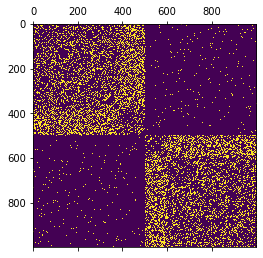

In [3]:
plt.matshow(net.A.toarray())

...but if we look closely, there's actually a 4x4 pattern here. The four blocks of this network correspond to the cases:

- $W=0,Z=0$
- $W=0, Z=1$
- $W=1,Z=0$
- $W=1,Z=1$

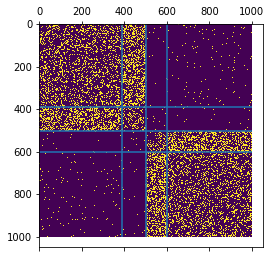

In [4]:
bounds = np.cumsum(net.block_sizes)[0:3]
plt.matshow(net.A.toarray())
plt.vlines(bounds, 0, n)
plt.hlines(bounds, 0, n)

## Ignoring Latent Variables

Suppose that we observe $Z$ but not $W$, and we wish to estimate the homophily effect for $Z$. We can use a simple GLM to estimate the following model:
$$
Y \sim \mathrm{Bernoulli}(\exp(\beta_0 + \beta_2 I(Z_i = Z_j)))
$$

Since the term $\beta_1 I(W_i = W_j)$ is missing, our estimate of $\beta_2$ will not reflect the latent homophily on $W$. In particular, since $W$ and $Z$ are correlated, our estimate will be heavily biased by the latent homophily on $W$.

In [5]:
def non_cluster_result(net):
    return estimation.reconcile_clusters(net, estimation.initial_cluster(net, 1, 1))

# Estimate coefficients for model, using a K=1 latent structure (i.e., no latent structure)
est_result = estimation.estimate(net, non_cluster_result(net))
# coefficients gives us the coefficients corresponding to the observed covariates
# the intercept is also estimated, but we don't output it here
est_result.coefficients

array([0.10778947])

Our estimate of $\beta_2$ is around 0.11, which is quite different from the true value of -0.5.

## Accounting for Latent Structure

Alternatively, we may account for the latent structure imposed by $W$ by fitting an arbitrary latent structure via the ACSBM. In particular, we'll fit:
$$
Y \sim \mathrm{ACSBM}(\theta, B, \beta_2, Z, \log) ,
$$
where $\theta$ and $B$ represent some latent block structure. Suppose we believe $K=2$ is the magic number of latent communities to fit. We may fit such a model like so:

In [6]:
initial = estimation.initial_cluster(net, k=2, d=4)
cluster_result = estimation.reconcile_clusters(net, initial)
est_result = estimation.estimate(net, cluster_result)

Before we look at the coefficients, let's see if we recovered the latent structure correctly.

In [7]:
utils.label_accuracy(net.theta, cluster_result.theta)

1.0

Indeed, we have **perfect** recovery of the latent structure. What exactly is this latent structure? In this case, the blocks of the latent community correspond to the unobserved variable $W$ (or possibly $1 - W$, since we can only identify things up to a permutation).

Since we have perfectly recovered the latent structure, the estimated coefficients should now be unbiased. Let's see how we do:

In [8]:
est_result.coefficients

array([-0.50049598])

That's much better!